In [32]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, List


In [33]:
def trapmf(x: np.ndarray, a: float, b: float, c: float, d: float) -> np.ndarray:
    """
    Trapezoidal membership function.
    Плечи (верхняя часть) начинаются с 1: плато между b и c равно 1.
    """
    y = np.zeros_like(x, dtype=float)

    # rising
    idx = (a < x) & (x < b)
    if b != a:
        y[idx] = (x[idx] - a) / (b - a)

    # plateau
    y[(b <= x) & (x <= c)] = 1.0

    # falling
    idx = (c < x) & (x < d)
    if d != c:
        y[idx] = (d - x[idx]) / (d - c)

    return np.clip(y, 0.0, 1.0)

def trimf(x: np.ndarray, a: float, b: float, c: float) -> np.ndarray:
    """Triangular MF = trapezoid with zero-length plateau at b."""
    return trapmf(x, a, b, b, c)


In [34]:
@dataclass(frozen=True)
class IT2Term:
    name: str
    mf_kind: str               # "trap" or "tri"
    umf_params: Tuple[float, ...]
    lmf_params: Tuple[float, ...]

    def umf(self, x: np.ndarray) -> np.ndarray:
        if self.mf_kind == "trap":
            return trapmf(x, *self.umf_params)
        if self.mf_kind == "tri":
            return trimf(x, *self.umf_params)
        raise ValueError(f"Unknown mf_kind={self.mf_kind}")

    def lmf(self, x: np.ndarray) -> np.ndarray:
        if self.mf_kind == "trap":
            return trapmf(x, *self.lmf_params)
        if self.mf_kind == "tri":
            return trimf(x, *self.lmf_params)
        raise ValueError(f"Unknown mf_kind={self.mf_kind}")


In [35]:
x = np.linspace(0, 10, 2001)

In [44]:
variables: Dict[str, List[IT2Term]] = {
    # 1) Производительность: сделаем "Средняя" треугольником, а крайние — трапециями
    r"Производительность разработчика $X$": [
        IT2Term("Низкая",  "trap", (0.0, 0.0, 2.2, 4.2), (0.0, 0.0, 1.7, 3.5)),
        IT2Term("Средняя", "tri",  (2.8, 5.0, 7.2),      (3.4, 5.0, 6.6)),
        IT2Term("Высокая", "trap", (6.0, 7.8, 10.0, 10.0), (6.7, 8.4, 10.0, 10.0)),
    ],

    # 2) Ожидания: пусть "Высокие" начинаются раньше (руководство быстрее повышает ожидания)
    r"Ожидания руководства": [
        IT2Term("Низкие",    "trap", (0.0, 0.0, 2.8, 5.0), (0.0, 0.0, 2.2, 4.2)),
        IT2Term("Умеренные", "trap", (3.5, 4.6, 6.0, 7.3), (3.9, 4.9, 5.7, 6.9)),
        IT2Term("Высокие",   "trap", (6.2, 7.0, 10.0, 10.0), (6.8, 7.6, 10.0, 10.0)),
    ],

    # 3) Бонус: часто "нет бонуса" занимает большую область, а "высокий" — узкая вершина
    r"Доп.\ бонус от руководства": [
        IT2Term("Отсутствует", "trap", (0.0, 0.0, 2.5, 5.5), (0.0, 0.0, 2.0, 4.8)),
        IT2Term("Умеренный",   "tri",  (3.5, 6.0, 8.0),      (4.2, 6.0, 7.4)),
        IT2Term("Высокий",     "trap", (7.2, 8.6, 10.0, 10.0), (7.8, 9.1, 10.0, 10.0)),
    ],

    # 4) Усталость: асимметрия — усталость растёт быстрее, чем “возвращается” (правая часть длиннее)
    r"Усталость разработчика $X$": [
        IT2Term("Низкая",  "trap", (0.0, 0.0, 2.0, 4.0), (0.0, 0.0, 1.6, 3.4)),
        IT2Term("Средняя", "trap", (2.8, 4.0, 5.5, 7.8), (3.4, 4.4, 5.3, 7.0)),
        IT2Term("Высокая", "trap", (6.2, 7.4, 10.0, 10.0), (6.8, 8.1, 10.0, 10.0)),
    ],

    # 5) Ошибки: обычно очень “шумная” величина → сделаем FOU шире
    r"Количество ошибок": [
        IT2Term("Малое",   "trap", (0.0, 0.0, 1.8, 4.6), (0.0, 0.0, 1.2, 3.6)),
        IT2Term("Среднее", "trap", (3.2, 4.4, 5.6, 7.6), (3.8, 4.9, 5.1, 6.9)),
        IT2Term("Большое", "trap", (6.0, 7.2, 10.0, 10.0), (6.8, 8.2, 10.0, 10.0)),
    ],

    # 6) Контроль: “жёсткий” контроль обычно включается резко → сделаем "Жёсткий" треугольником
    r"Контроль со стороны руководства": [
        IT2Term("Слабый",    "trap", (0.0, 0.0, 2.6, 4.4), (0.0, 0.0, 2.0, 3.6)),
        IT2Term("Умеренный", "trap", (3.5, 4.8, 5.8, 7.0), (4.0, 5.1, 5.6, 6.6)),
        IT2Term("Жёсткий",   "trap",  (6.2, 8.4, 10.0, 10.0),     (6.8, 8.6, 10.0, 10.0)),
    ],

    # 7) Напряжение: похоже на усталость, но может быстро “скакать” → среднее сделаем треугольным
    r"Напряжение разработчика $X$": [
        IT2Term("Низкое",  "trap", (0.0, 0.0, 2.4, 4.8), (0.0, 0.0, 1.8, 4.0)),
        IT2Term("Среднее", "tri",  (3.2, 5.3, 7.4),      (3.8, 5.3, 6.8)),
        IT2Term("Высокое", "trap", (6.0, 7.6, 10.0, 10.0), (6.6, 8.2, 10.0, 10.0)),
    ],
}


In [37]:
def plot_variable_terms(var_name: str, terms: List[IT2Term], x: np.ndarray) -> None:
    fig, ax = plt.subplots(figsize=(8.2, 3.4))
    ax.set_title(var_name)
    ax.set_xlabel("x (нормированная шкала 0..10)")
    ax.set_ylabel("степень принадлежности")
    ax.set_ylim(-0.02, 1.05)
    ax.set_xlim(x.min(), x.max())
    ax.grid(True, alpha=0.25)

    for term in terms:
        y_u = term.umf(x)
        y_l = term.lmf(x)

        line_u, = ax.plot(x, y_u, label=f"{term.name} (UMF)")
        ax.plot(x, y_l, linestyle="--", color=line_u.get_color(), label=f"{term.name} (LMF)")
        ax.fill_between(x, y_l, y_u, alpha=0.15, color=line_u.get_color())

    ax.legend(ncols=3, fontsize=8, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.18))
    plt.tight_layout()
    plt.show()

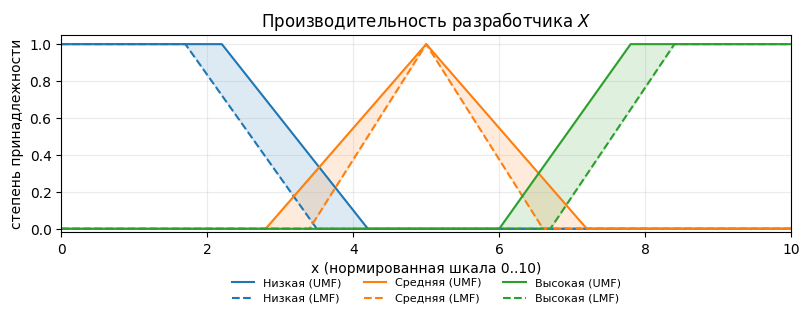

In [38]:
plot_variable_terms(r"Производительность разработчика $X$", variables[r"Производительность разработчика $X$"], x)

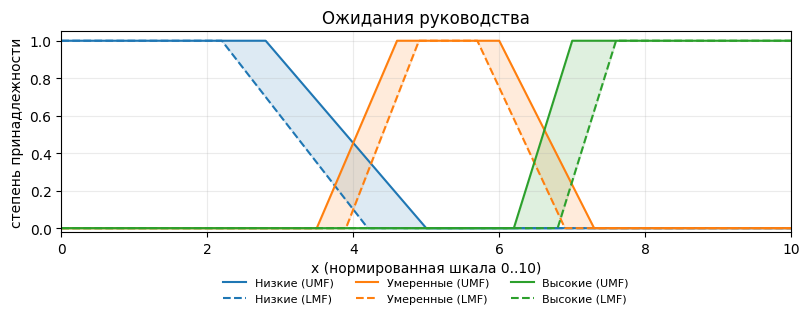

In [39]:
plot_variable_terms(r"Ожидания руководства", variables[r"Ожидания руководства"], x)

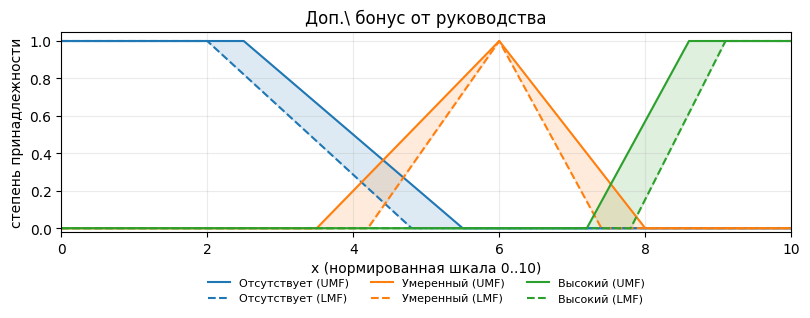

In [40]:
plot_variable_terms(r"Доп.\ бонус от руководства", variables[r"Доп.\ бонус от руководства"], x)

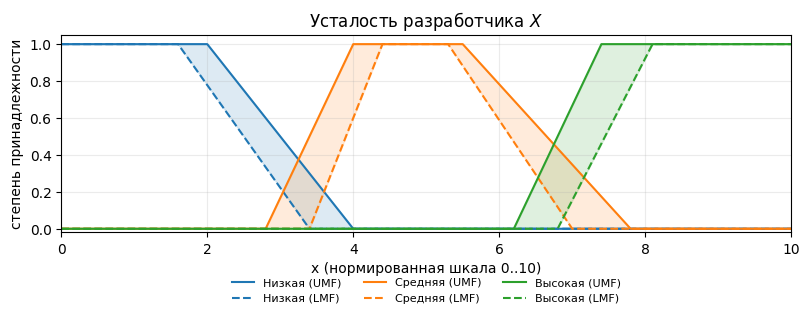

In [41]:
plot_variable_terms(r"Усталость разработчика $X$", variables[r"Усталость разработчика $X$"], x)

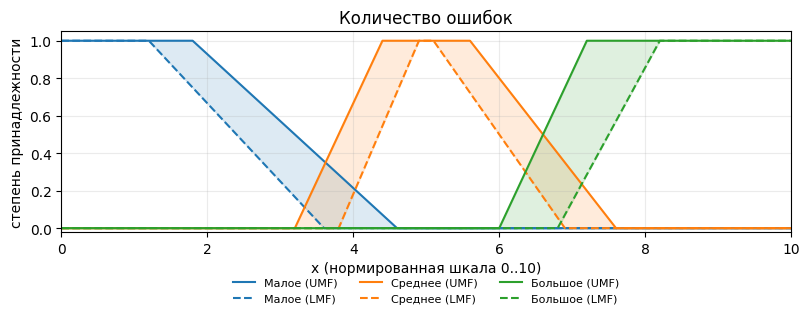

In [42]:
plot_variable_terms(r"Количество ошибок", variables[r"Количество ошибок"], x)

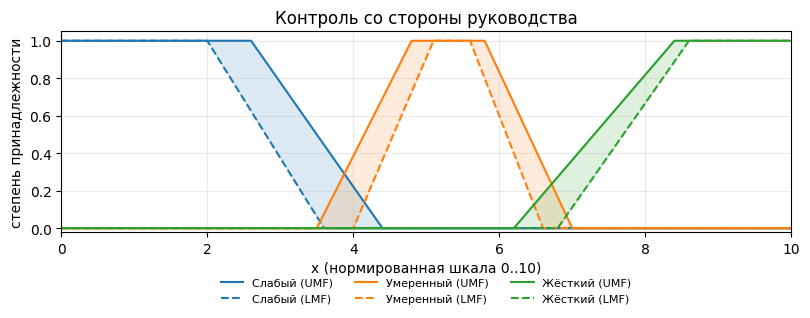

In [45]:
plot_variable_terms(r"Контроль со стороны руководства", variables[r"Контроль со стороны руководства"], x)

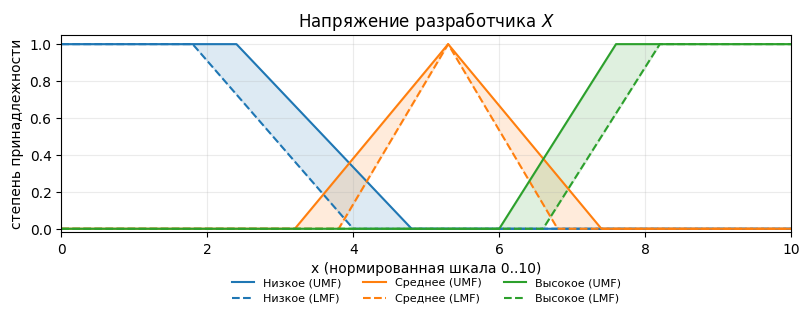

In [46]:
plot_variable_terms(r"Напряжение разработчика $X$", variables[r"Напряжение разработчика $X$"], x)

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple

In [60]:
t_labels = [r"$t_5'$", r"$t_4'$", r"$t_3'$", r"$t_2'$", r"$t_1'$", r"$t_0$"]
t = np.arange(len(t_labels))

In [61]:
term_labels: Dict[str, Tuple[str, str, str]] = {
    "P":   ("Низкая", "Средняя", "Высокая"),
    "E":   ("Низкие", "Умеренные", "Высокие"),
    "B":   ("Отсутствует", "Умеренный", "Высокий"),
    "F":   ("Низкая", "Средняя", "Высокая"),
    "Err": ("Малое", "Среднее", "Большое"),
    "Ctrl":("Слабый", "Умеренный", "Жёсткий"),
    "Tens":("Низкое", "Среднее", "Высокое"),
}

pretty_name: Dict[str, str] = {
    "P":   r"Производительность разработчика $X$",
    "E":   r"Ожидания руководства",
    "B":   r"Доп.\ бонус от руководства",
    "F":   r"Усталость разработчика $X$",
    "Err": r"Количество ошибок",
    "Ctrl":r"Контроль со стороны руководства",
    "Tens":r"Напряжение разработчика $X$",
}

In [62]:
bot_levels: Dict[str, List[int]] = {
    # t5'  t4  t3  t2  t1  t0
    "P":   [2,  2,  1,  1,  0,  0],  # производительность падает с High до Low
    "E":   [1,  2,  2,  1,  1,  0],  # ожидания сначала высокие, затем снижаются
    "B":   [1,  1,  2,  2,  1,  0],  # бонус реагирует не сразу и затем сокращается
    "F":   [1,  1,  2,  2,  2,  2],  # усталость растёт и держится высокой
    "Err": [0,  1,  1,  2,  2,  2],  # ошибки растут с лагом от усталости
    "Ctrl":[0,  0,  1,  1,  2,  2],  # контроль растёт с лагом от ошибок
    "Tens":[0,  0,  0,  1,  2,  2],  # напряжение растёт с лагом от контроля
}

In [63]:
# Функция для построения одного BOT-графика

def plot_bot(var_key: str) -> None:
    levels = bot_levels[var_key]
    y0, y1, y2 = term_labels[var_key]

    fig, ax = plt.subplots(figsize=(7.2, 2.8))
    ax.plot(t, levels, marker="o")
    ax.set_title(pretty_name[var_key])
    ax.set_xlabel("t (недели)")
    ax.set_ylabel("терм")

    ax.set_xticks(t)
    ax.set_xticklabels(t_labels)

    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels([y0, y1, y2])

    ax.set_ylim(-0.2, 2.2)
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

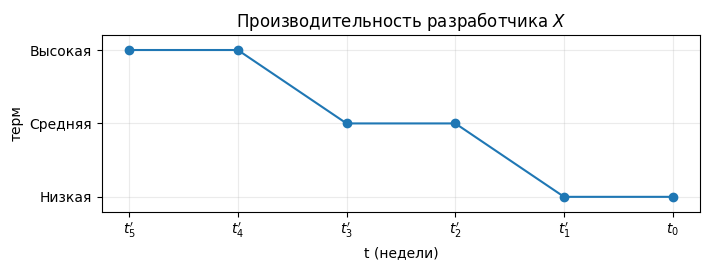

In [64]:
plot_bot("P")

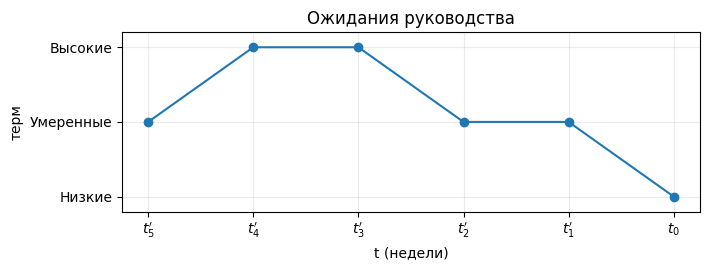

In [65]:
plot_bot("E")

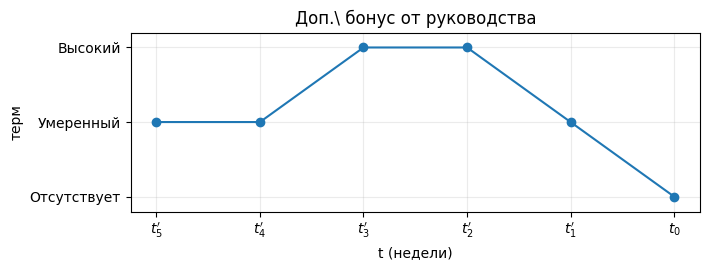

In [66]:
plot_bot("B")

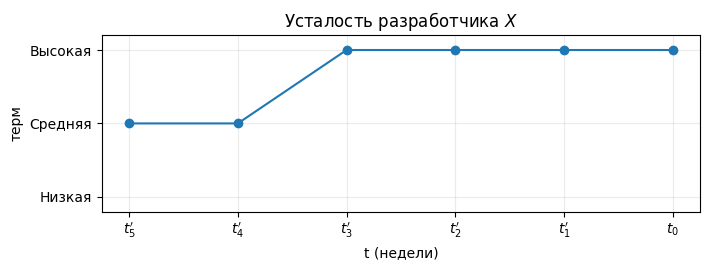

In [67]:
plot_bot("F")

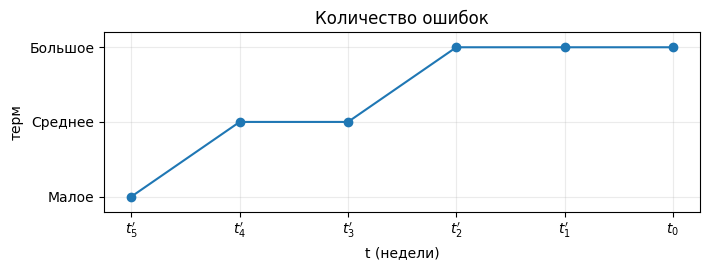

In [68]:
plot_bot("Err")

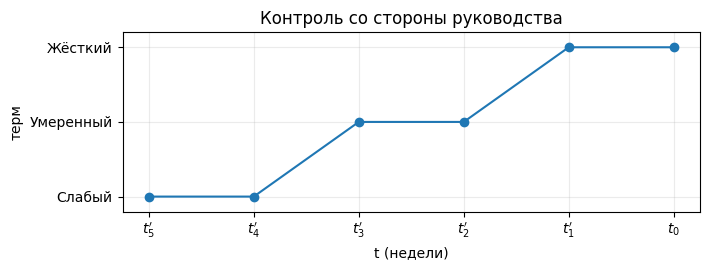

In [69]:
plot_bot("Ctrl")

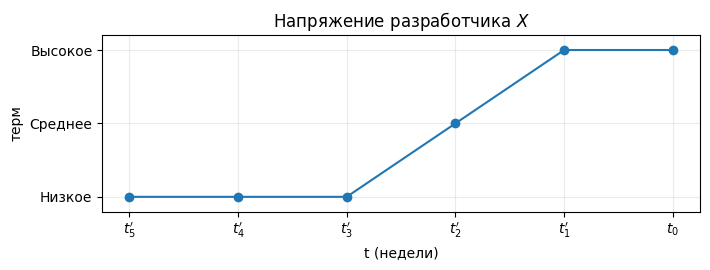

In [70]:
plot_bot("Tens")

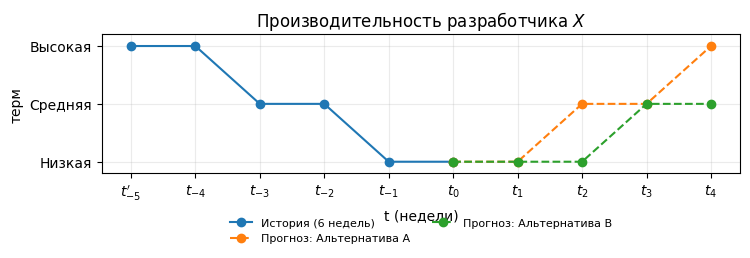

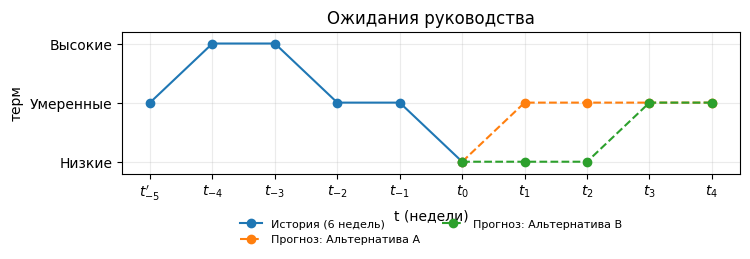

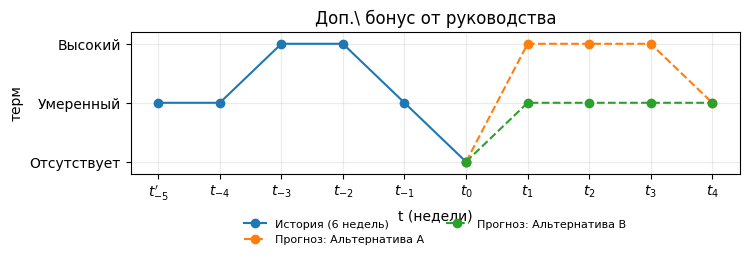

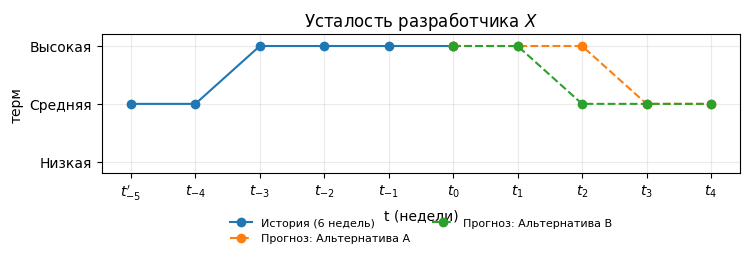

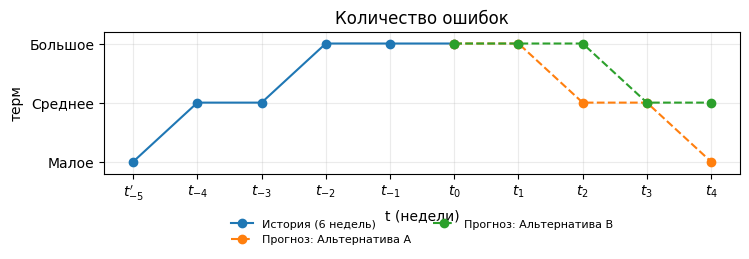

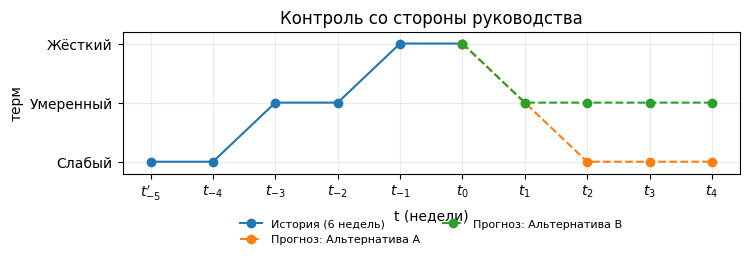

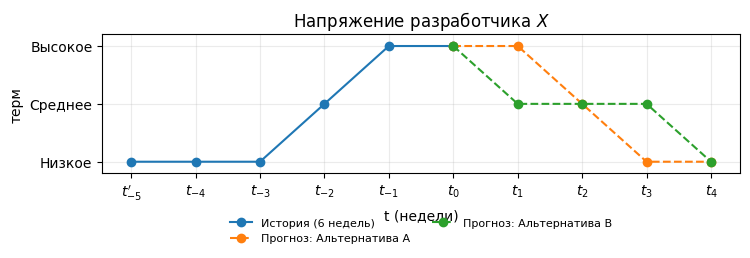

In [72]:
import numpy as np
import matplotlib.pyplot as plt


past_labels = [r"$t_{-5}'$", r"$t_{-4}$", r"$t_{-3}$", r"$t_{-2}$", r"$t_{-1}$", r"$t_{0}$"]
future_labels = [r"$t_{1}$", r"$t_{2}$", r"$t_{3}$", r"$t_{4}$"]
labels = past_labels + future_labels

t_all = np.arange(len(labels))
t_past = np.arange(len(past_labels))                 # 0..5
t_future = np.arange(len(past_labels)-1, len(labels)) # 5..9 (начиная с t0)


term_labels = {
    "P":   ("Низкая", "Средняя", "Высокая"),
    "E":   ("Низкие", "Умеренные", "Высокие"),
    "B":   ("Отсутствует", "Умеренный", "Высокий"),
    "F":   ("Низкая", "Средняя", "Высокая"),
    "Err": ("Малое", "Среднее", "Большое"),
    "Ctrl":("Слабый", "Умеренный", "Жёсткий"),
    "Tens":("Низкое", "Среднее", "Высокое"),
}

pretty_name = {
    "P":   r"Производительность разработчика $X$",
    "E":   r"Ожидания руководства",
    "B":   r"Доп.\ бонус от руководства",
    "F":   r"Усталость разработчика $X$",
    "Err": r"Количество ошибок",
    "Ctrl":r"Контроль со стороны руководства",
    "Tens":r"Напряжение разработчика $X$",
}


past = {
    # t-5' t-4 t-3 t-2 t-1 t0
    "P":   [2,   2,  1,  1,  0,  0],
    "E":   [1,   2,  2,  1,  1,  0],
    "B":   [1,   1,  2,  2,  1,  0],
    "F":   [1,   1,  2,  2,  2,  2],
    "Err": [0,   1,  1,  2,  2,  2],
    "Ctrl":[0,   0,  1,  1,  2,  2],
    "Tens":[0,   0,  0,  1,  2,  2],
}


# Альтернатива A: снизить ожидания + снизить контроль + повысить бонус
# Логика задержек:
# - Ctrl снижается сразу (t1), Tens снижается через ~1 неделю, F через ещё ~1, Err ещё ~1.
# - Бонус повышается сразу, но P заметно растёт с лагом ~2 недели.
future_A = {
    "E":    [past["E"][-1], 1, 1, 1, 1],   # t0=0 -> умеренные
    "Ctrl": [past["Ctrl"][-1], 1, 0, 0, 0],# t0=2 -> быстро к умер/слаб
    "B":    [past["B"][-1], 2, 2, 2, 1],   # высокий бонус, потом стабилизация
    "Tens": [past["Tens"][-1], 2, 1, 0, 0],# напряжение падает с лагом
    "F":    [past["F"][-1], 2, 2, 1, 1],   # усталость начинает спадать позже
    "Err":  [past["Err"][-1], 2, 1, 1, 0], # ошибки снижаются ещё позже
    "P":    [past["P"][-1], 0, 1, 1, 2],   # восстановление: сначала стабилизация, затем рост
}

# Альтернатива B: снизить ожидания сильнее, контроль оставить умеренным, бонус умеренный
future_B = {
    "E":    [past["E"][-1], 0, 0, 1, 1],   # “дать выдохнуть” на 1–2 недели
    "Ctrl": [past["Ctrl"][-1], 1, 1, 1, 1],# убрать жёсткий контроль, но держать умеренный
    "B":    [past["B"][-1], 1, 1, 1, 1],   # умеренная мотивация без “перекоса”
    "Tens": [past["Tens"][-1], 1, 1, 1, 0],# напряжение падает плавнее
    "F":    [past["F"][-1], 2, 1, 1, 1],   # усталость начинает снижаться раньше, но медленнее
    "Err":  [past["Err"][-1], 2, 2, 1, 1], # ошибки снижаются плавно
    "P":    [past["P"][-1], 0, 0, 1, 1],   # рост более осторожный (стабилизация -> средняя)
}

# Соберём полный ряд (прошлое + будущее без дублирования t0)
def merge_series(past_vals, future_vals_including_t0):
    # past already includes t0 at the end
    return past_vals + future_vals_including_t0[1:]  # добавляем t1..t4


def plot_bot_two_scenarios(var_key: str):
    y0, y1, y2 = term_labels[var_key]

    series_A = merge_series(past[var_key], future_A[var_key])
    series_B = merge_series(past[var_key], future_B[var_key])

    fig, ax = plt.subplots(figsize=(7.6, 2.9))
    ax.set_title(pretty_name[var_key])
    ax.set_xlabel("t (недели)")
    ax.set_ylabel("терм")

    ax.set_xticks(t_all)
    ax.set_xticklabels(labels)

    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels([y0, y1, y2])
    ax.set_ylim(-0.2, 2.2)
    ax.grid(True, alpha=0.25)

    # past (общая история)
    ax.plot(t_past, past[var_key], marker="o", label="История (6 недель)")

    # future (пунктир): t0..t4
    ax.plot(t_future, future_A[var_key], linestyle="--", marker="o", label="Прогноз: Альтернатива A")
    ax.plot(t_future, future_B[var_key], linestyle="--", marker="o", label="Прогноз: Альтернатива B")

    ax.legend(frameon=False, fontsize=8, loc="upper center", bbox_to_anchor=(0.5, -0.25), ncols=2)
    plt.tight_layout()
    plt.show()

# Построим графики для всех переменных
for k in ["P", "E", "B", "F", "Err", "Ctrl", "Tens"]:
    plot_bot_two_scenarios(k)


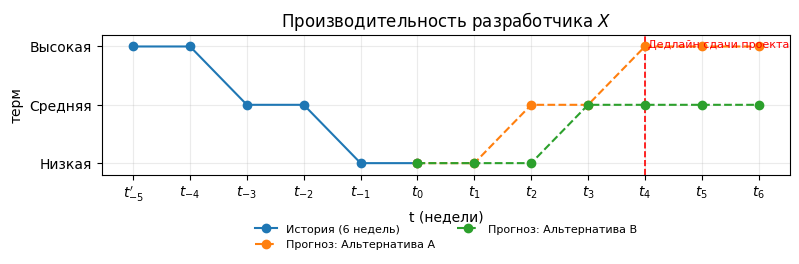

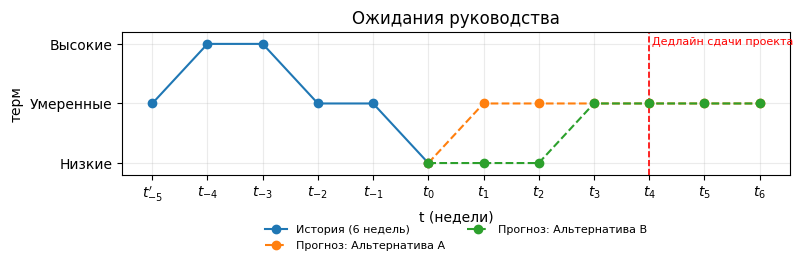

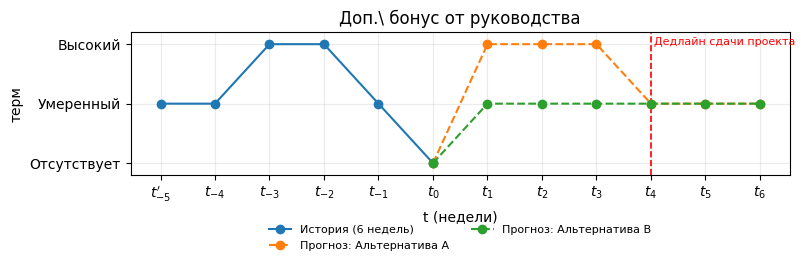

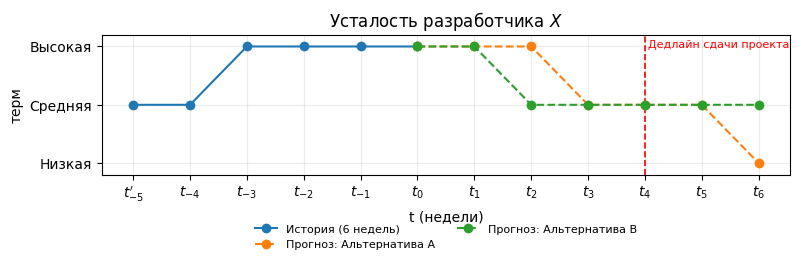

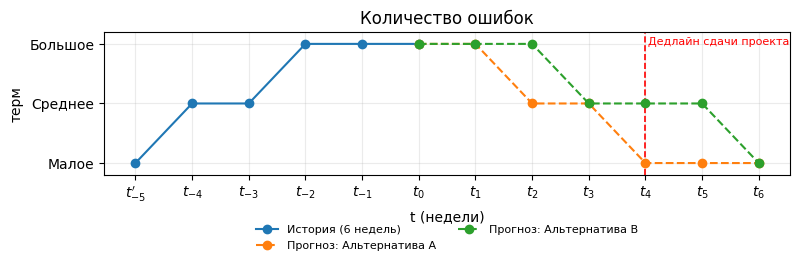

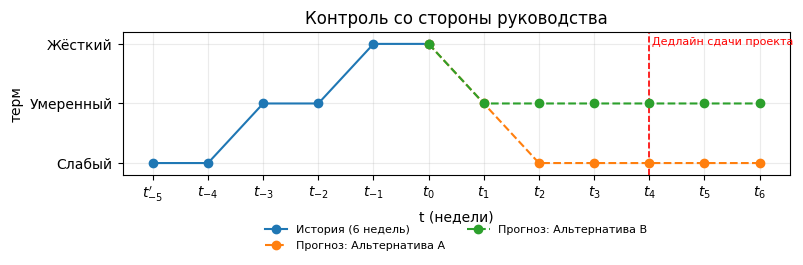

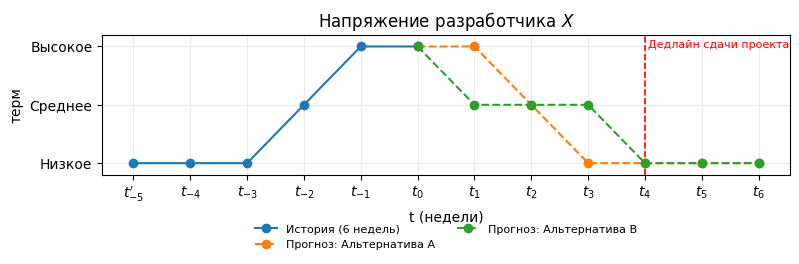

In [74]:
import numpy as np
import matplotlib.pyplot as plt


past_labels = [r"$t_{-5}'$", r"$t_{-4}$", r"$t_{-3}$", r"$t_{-2}$", r"$t_{-1}$", r"$t_{0}$"]
future_labels = [r"$t_{1}$", r"$t_{2}$", r"$t_{3}$", r"$t_{4}$", r"$t_{5}$", r"$t_{6}$"]
labels = past_labels + future_labels

t_all = np.arange(len(labels))  # 0..11
t_past = np.arange(len(past_labels))  # 0..5
t_future = np.arange(len(past_labels)-1, len(labels))  # 5..11 (t0..t6)

# Индекс точки t4 (для вертикальной линии дедлайна)
deadline_label = r"$t_{4}$"
deadline_idx = labels.index(deadline_label)


term_labels = {
    "P":   ("Низкая", "Средняя", "Высокая"),
    "E":   ("Низкие", "Умеренные", "Высокие"),
    "B":   ("Отсутствует", "Умеренный", "Высокий"),
    "F":   ("Низкая", "Средняя", "Высокая"),
    "Err": ("Малое", "Среднее", "Большое"),
    "Ctrl":("Слабый", "Умеренный", "Жёсткий"),
    "Tens":("Низкое", "Среднее", "Высокое"),
}

pretty_name = {
    "P":   r"Производительность разработчика $X$",
    "E":   r"Ожидания руководства",
    "B":   r"Доп.\ бонус от руководства",
    "F":   r"Усталость разработчика $X$",
    "Err": r"Количество ошибок",
    "Ctrl":r"Контроль со стороны руководства",
    "Tens":r"Напряжение разработчика $X$",
}


past = {
    # t-5' t-4 t-3 t-2 t-1 t0
    "P":   [2,   2,  1,  1,  0,  0],
    "E":   [1,   2,  2,  1,  1,  0],
    "B":   [1,   1,  2,  2,  1,  0],
    "F":   [1,   1,  2,  2,  2,  2],
    "Err": [0,   1,  1,  2,  2,  2],
    "Ctrl":[0,   0,  1,  1,  2,  2],
    "Tens":[0,   0,  0,  1,  2,  2],
}


# Альтернатива A: снизить ожидания + снизить контроль + повысить бонус
future_A = {
    "E":    [past["E"][-1], 1, 1, 1, 1, 1, 1],
    "Ctrl": [past["Ctrl"][-1], 1, 0, 0, 0, 0, 0],
    "B":    [past["B"][-1], 2, 2, 2, 1, 1, 1],
    "Tens": [past["Tens"][-1], 2, 1, 0, 0, 0, 0],
    "F":    [past["F"][-1], 2, 2, 1, 1, 1, 0],
    "Err":  [past["Err"][-1], 2, 1, 1, 0, 0, 0],
    "P":    [past["P"][-1], 0, 1, 1, 2, 2, 2],
}

# Альтернатива B: ожидания сильно вниз на 1–2 недели, контроль умеренный, бонус умеренный
future_B = {
    "E":    [past["E"][-1], 0, 0, 1, 1, 1, 1],
    "Ctrl": [past["Ctrl"][-1], 1, 1, 1, 1, 1, 1],
    "B":    [past["B"][-1], 1, 1, 1, 1, 1, 1],
    "Tens": [past["Tens"][-1], 1, 1, 1, 0, 0, 0],
    "F":    [past["F"][-1], 2, 1, 1, 1, 1, 1],
    "Err":  [past["Err"][-1], 2, 2, 1, 1, 1, 0],
    "P":    [past["P"][-1], 0, 0, 1, 1, 1, 1],
}

def merge_series(past_vals, future_vals_including_t0):
    # past already includes t0 at the end; append t1..t6
    return past_vals + future_vals_including_t0[1:]


def plot_bot_two_scenarios(var_key: str):
    y0, y1, y2 = term_labels[var_key]

    series_A = merge_series(past[var_key], future_A[var_key])
    series_B = merge_series(past[var_key], future_B[var_key])

    fig, ax = plt.subplots(figsize=(8.2, 3.0))
    ax.set_title(pretty_name[var_key])
    ax.set_xlabel("t (недели)")
    ax.set_ylabel("терм")

    ax.set_xticks(t_all)
    ax.set_xticklabels(labels)

    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels([y0, y1, y2])
    ax.set_ylim(-0.2, 2.2)
    ax.grid(True, alpha=0.25)

    # Дедлайн: вертикальная красная пунктирная линия на t4
    ax.axvline(deadline_idx, linestyle="--", color="red", linewidth=1.2)
    ax.text(deadline_idx + 0.05, 2.12, "Дедлайн сдачи проекта", color="red", fontsize=8, va="top")

    # История
    ax.plot(t_past, past[var_key], marker="o", label="История (6 недель)")

    # Прогноз (t0..t6) пунктиром
    ax.plot(t_future, future_A[var_key], linestyle="--", marker="o", label="Прогноз: Альтернатива A")
    ax.plot(t_future, future_B[var_key], linestyle="--", marker="o", label="Прогноз: Альтернатива B")

    ax.legend(frameon=False, fontsize=8, loc="upper center", bbox_to_anchor=(0.5, -0.28), ncols=2)
    plt.tight_layout()
    plt.show()

# Построить все графики
for k in ["P", "E", "B", "F", "Err", "Ctrl", "Tens"]:
    plot_bot_two_scenarios(k)


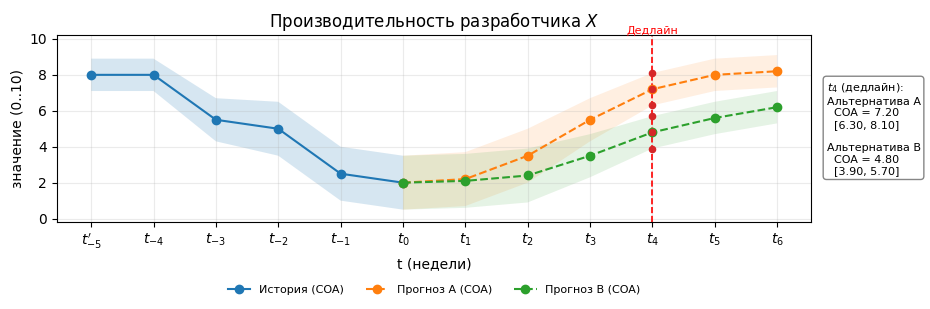

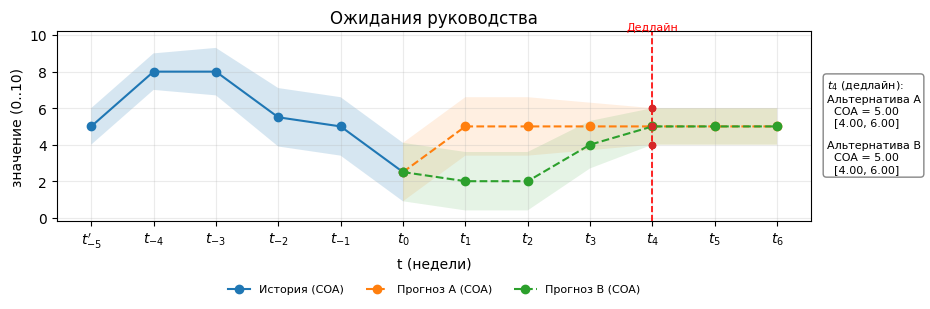

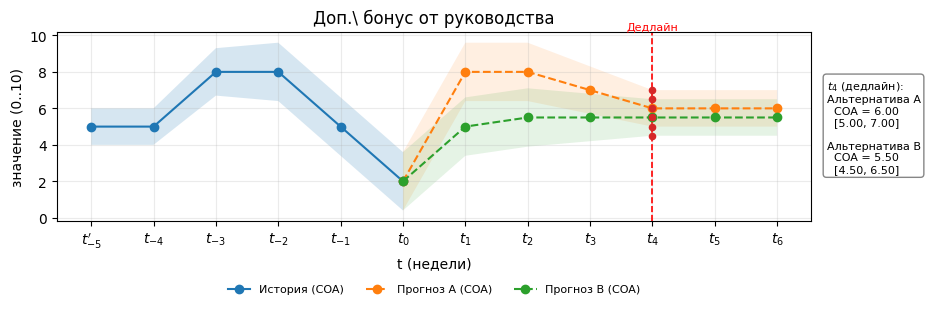

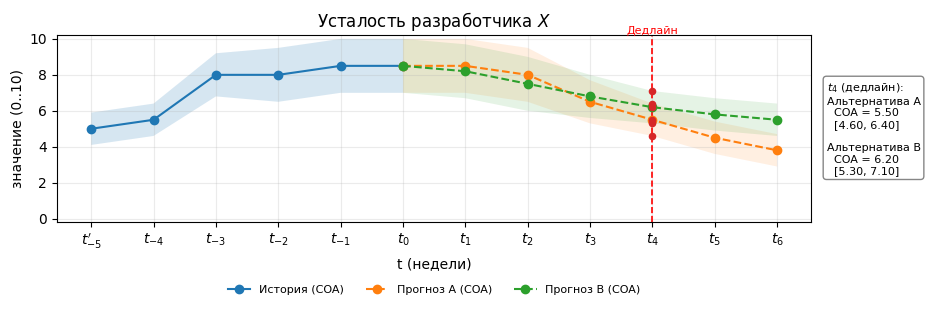

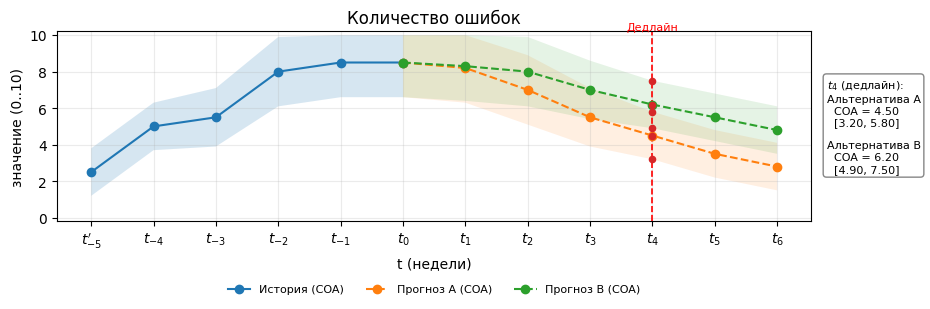

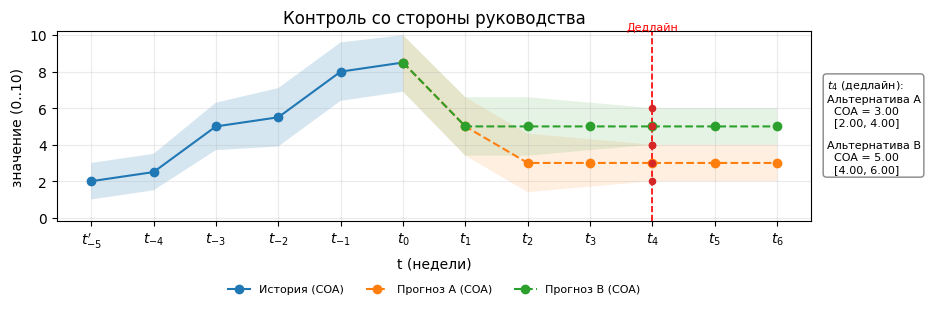

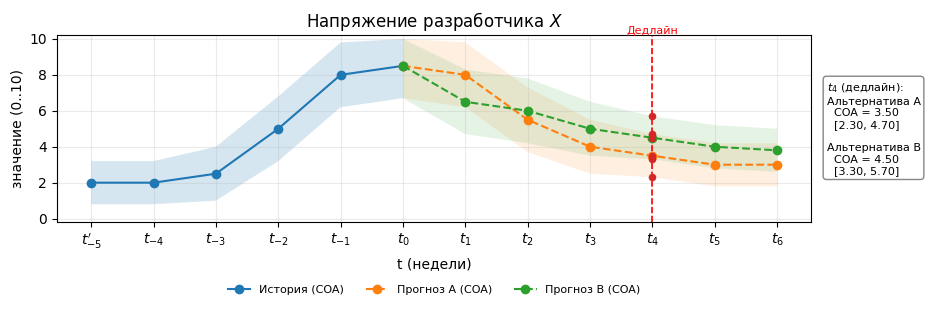

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 0) Ось времени: прошлое t_{-5}'..t_0 (6 недель) + прогноз t_1..t_6 (6 недель)
# ============================================================
past_labels   = [r"$t_{-5}'$", r"$t_{-4}$", r"$t_{-3}$", r"$t_{-2}$", r"$t_{-1}$", r"$t_{0}$"]
future_labels = [r"$t_{1}$", r"$t_{2}$", r"$t_{3}$", r"$t_{4}$", r"$t_{5}$", r"$t_{6}$"]
labels = past_labels + future_labels

t_all = np.arange(len(labels))              # 0..11
t_past = np.arange(len(past_labels))        # 0..5
t_future = np.arange(len(past_labels)-1, len(labels))  # 5..11 (t0..t6)

deadline_label = r"$t_{4}$"
deadline_idx = labels.index(deadline_label)

# ============================================================
# 1) Переменные
# ============================================================
keys = ["P", "E", "B", "F", "Err", "Ctrl", "Tens"]

pretty_name = {
    "P":   r"Производительность разработчика $X$",
    "E":   r"Ожидания руководства",
    "B":   r"Доп.\ бонус от руководства",
    "F":   r"Усталость разработчика $X$",
    "Err": r"Количество ошибок",
    "Ctrl":r"Контроль со стороны руководства",
    "Tens":r"Напряжение разработчика $X$",
}

# ============================================================
# 2) История (6 недель) — теперь в числах 0..10 + интервал неопределённости
#    Чтобы сохранить смысл из предыдущих "термов", используем грубое отображение:
#    low~2, medium~5, high~8, но дальше работаем именно с числами.
# ============================================================
# Исторические COA-значения (0..10)
past_coa = {
    # t-5' t-4  t-3  t-2  t-1  t0
    "P":    [8.0, 8.0, 5.5, 5.0, 2.5, 2.0],   # падение High->Low
    "E":    [5.0, 8.0, 8.0, 5.5, 5.0, 2.5],
    "B":    [5.0, 5.0, 8.0, 8.0, 5.0, 2.0],
    "F":    [5.0, 5.5, 8.0, 8.0, 8.5, 8.5],
    "Err":  [2.5, 5.0, 5.5, 8.0, 8.5, 8.5],
    "Ctrl": [2.0, 2.5, 5.0, 5.5, 8.0, 8.5],
    "Tens": [2.0, 2.0, 2.5, 5.0, 8.0, 8.5],
}

# Базовая "ширина неопределённости" (FOU-ширина по смыслу)
base_unc = {
    "P": 0.9,
    "E": 1.0,
    "B": 1.0,
    "F": 0.9,
    "Err": 1.3,   # ошибки обычно оцениваются шумнее
    "Ctrl": 1.0,
    "Tens": 1.2,  # стресс тоже шумный
}

# Доп. неопределённость в "турбулентные" недели (t-2..t1 вокруг кризиса)
# Индексы в истории: t-2=3, t-1=4, t0=5. В будущем: t1 соответствует глобальному индексу 6.
def time_unc_boost(global_idx: int) -> float:
    # сделаем пик неопределённости около t0..t2
    if global_idx in [3, 4, 5, 6, 7]:
        return 0.6
    if global_idx in [2, 8]:
        return 0.3
    return 0.0

def make_bounds_from_coa(coa_series, var_key: str):
    """
    Возвращает L(t), U(t), COA(t) для серии на общем таймлайне.
    """
    coa = np.array(coa_series, dtype=float)
    L = np.zeros_like(coa)
    U = np.zeros_like(coa)
    for i in range(len(coa)):
        delta = base_unc[var_key] + time_unc_boost(i)
        L[i] = max(0.0, coa[i] - delta)
        U[i] = min(10.0, coa[i] + delta)
    return L, U, coa

# ============================================================
# 3) Прогнозы (две альтернативы) как численные траектории COA + интервалы
#    Формат прогнозов: [t0, t1, t2, t3, t4, t5, t6]
# ============================================================

# --- Альтернатива A: снизить ожидания + резко ослабить контроль + поднять бонус ---
# Лаги согласованы:
# Ctrl снижаем сразу -> Tens начинает падать со сдвигом -> F затем -> Err затем -> P растёт позже.
future_coa_A = {
    "E":    [past_coa["E"][-1], 5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
    "Ctrl": [past_coa["Ctrl"][-1], 5.0, 3.0, 3.0, 3.0, 3.0, 3.0],
    "B":    [past_coa["B"][-1], 8.0, 8.0, 7.0, 6.0, 6.0, 6.0],

    "Tens": [past_coa["Tens"][-1], 8.0, 5.5, 4.0, 3.5, 3.0, 3.0],
    "F":    [past_coa["F"][-1],    8.5, 8.0, 6.5, 5.5, 4.5, 3.8],
    "Err":  [past_coa["Err"][-1],  8.2, 7.0, 5.5, 4.5, 3.5, 2.8],
    "P":    [past_coa["P"][-1],    2.2, 3.5, 5.5, 7.2, 8.0, 8.2],  # к дедлайну t4 выходит на высокий уровень
}

# --- Альтернатива B: ожидания сильно снизить на 1–2 недели, контроль = умеренный, бонус = умеренный ---
# Восстановление более плавное и "управляемое"
future_coa_B = {
    "E":    [past_coa["E"][-1], 2.0, 2.0, 4.0, 5.0, 5.0, 5.0],
    "Ctrl": [past_coa["Ctrl"][-1], 5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
    "B":    [past_coa["B"][-1], 5.0, 5.5, 5.5, 5.5, 5.5, 5.5],

    "Tens": [past_coa["Tens"][-1], 6.5, 6.0, 5.0, 4.5, 4.0, 3.8],
    "F":    [past_coa["F"][-1],    8.2, 7.5, 6.8, 6.2, 5.8, 5.5],
    "Err":  [past_coa["Err"][-1],  8.3, 8.0, 7.0, 6.2, 5.5, 4.8],
    "P":    [past_coa["P"][-1],    2.1, 2.4, 3.5, 4.8, 5.6, 6.2],  # к t6 выходит на "средне-высокую"
}

def merge_coa(past_vals, future_vals_including_t0):
    # past already contains t0 at the end -> append t1..t6
    return list(past_vals) + list(future_vals_including_t0[1:])

# Полные COA на всём горизонте (t-5'..t6)
coa_A_full = {k: merge_coa(past_coa[k], future_coa_A[k]) for k in keys}
coa_B_full = {k: merge_coa(past_coa[k], future_coa_B[k]) for k in keys}

# ============================================================
# 4) Функции графика: показываем L/U (интервал) и COA (центр)
#    - История (6 недель): сплошное
#    - Прогноз (t0..t6): пунктир для каждой альтернативы
#    - Дедлайн t4: вертикальная красная пунктирная линия + подпись
# ============================================================

def bounds_full_from_coa_full(coa_full, var_key):
    L, U, C = make_bounds_from_coa(coa_full, var_key)
    return L, U, C

def plot_it2_bot_two_scenarios(var_key: str):
    # Готовим полные серии
    L_A, U_A, C_A = bounds_full_from_coa_full(coa_A_full[var_key], var_key)
    L_B, U_B, C_B = bounds_full_from_coa_full(coa_B_full[var_key], var_key)

    # История (6 недель)
    L_hist = L_A[:len(past_labels)]
    U_hist = U_A[:len(past_labels)]
    C_hist = C_A[:len(past_labels)]

    # Прогноз (с t0)
    idx0 = len(past_labels) - 1
    L_A_f, U_A_f, C_A_f = L_A[idx0:], U_A[idx0:], C_A[idx0:]
    L_B_f, U_B_f, C_B_f = L_B[idx0:], U_B[idx0:], C_B[idx0:]

    fig, ax = plt.subplots(figsize=(9.4, 3.4))
    ax.set_title(pretty_name[var_key])
    ax.set_xlabel("t (недели)")
    ax.set_ylabel("значение (0..10)")

    ax.set_xticks(t_all)
    ax.set_xticklabels(labels)
    ax.set_ylim(-0.2, 10.2)
    ax.grid(True, alpha=0.25)

    # --- Дедлайн ---
    ax.axvline(deadline_idx, linestyle="--", color="red", linewidth=1.2)
    ax.text(deadline_idx, 10.15, "Дедлайн", color="red",
            fontsize=8, ha="center", va="bottom")

    # --- История ---
    ax.fill_between(t_past, L_hist, U_hist, alpha=0.18)
    ax.plot(t_past, C_hist, marker="o", label="История (COA)")

    # --- Прогноз A ---
    ax.fill_between(t_future, L_A_f, U_A_f, alpha=0.12)
    ax.plot(t_future, C_A_f, linestyle="--", marker="o", label="Прогноз A (COA)")

    # --- Прогноз B ---
    ax.fill_between(t_future, L_B_f, U_B_f, alpha=0.12)
    ax.plot(t_future, C_B_f, linestyle="--", marker="o", label="Прогноз B (COA)")

    # ============================================================
    # Точки пересечения с дедлайном (БЕЗ подписей на графике)
    # ============================================================
    ax.scatter(
        [deadline_idx]*6,
        [L_A[deadline_idx], C_A[deadline_idx], U_A[deadline_idx],
         L_B[deadline_idx], C_B[deadline_idx], U_B[deadline_idx]],
        s=20, zorder=5
    )

    # ============================================================
    # Информационный блок СПРАВА
    # ============================================================
    info_text = (
        r"$t_4$ (дедлайн):" "\n"
        r"Альтернатива A" "\n"
        f"  COA = {C_A[deadline_idx]:.2f}\n"
        f"  [{L_A[deadline_idx]:.2f}, {U_A[deadline_idx]:.2f}]\n\n"
        r"Альтернатива B" "\n"
        f"  COA = {C_B[deadline_idx]:.2f}\n"
        f"  [{L_B[deadline_idx]:.2f}, {U_B[deadline_idx]:.2f}]"
    )

    ax.text(
        1.02, 0.5, info_text,
        transform=ax.transAxes,
        fontsize=8,
        va="center",
        bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.95)
    )

    ax.legend(
        frameon=False,
        fontsize=8,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.28),
        ncols=3
    )

    plt.tight_layout()
    plt.show()


# Построить все графики
for k in keys:
    plot_it2_bot_two_scenarios(k)
